In [37]:
import numpy as np
import pandas as pd
import gc
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from contextlib import contextmanager
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
def one_hot_encoder(df, nan_as_category = True):
    '''One-hot encoding for categorical columns with get_dummies'''

    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]

    return df, new_columns

In [4]:
def application_train_test(num_rows = None, nan_as_category = False):
    '''Preprocess application_train.csv and application_test.csv'''
    
    # Read data and merge
    df = pd.read_csv('data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    
    return df

In [5]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    '''Preprocess bureau.csv and bureau_balance.csv'''
    
    bureau = pd.read_csv('data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

In [6]:
def previous_applications(num_rows = None, nan_as_category = True):
    '''Preprocess previous_applications.csv'''
    
    prev = pd.read_csv('data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg

In [7]:
def pos_cash(num_rows = None, nan_as_category = True):
    '''Preprocess POS_CASH_balance.csv'''

    pos = pd.read_csv('data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()

    return pos_agg

In [8]:
def installments_payments(num_rows = None, nan_as_category = True):
    '''Preprocess installments_payments.csv'''
    
    ins = pd.read_csv('data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()

    return ins_agg

In [9]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    '''Preprocess credit_card_balance.csv'''
    
    cc = pd.read_csv('data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    
    return cc_agg

In [10]:
def main(debug = False):
    '''Runs all functions above'''
    
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Saving final dataset"):
        df.to_csv("final_dataset.csv")

In [11]:
main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 27s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 43s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 22s
Installments payments df shape: (339587, 26)
Process installments payments - done in 47s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 35s
Saving final dataset - done in 215s


In [14]:
df = pd.read_csv('final_dataset.csv', index_col=0)

In [15]:
df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Divide in training/validation and test data
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
del df
gc.collect()

Train shape: (307507, 798), test shape: (48744, 798)


2149

In [26]:
# Create k-fold cross validation instance
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

In [27]:
# Remove special characters
train_df = train_df.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [28]:
train_df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
from lightgbm import LGBMClassifier
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(n_estimators=10000, objective = 'binary',
                         class_weight = 'balanced', learning_rate = 0.05,
                         reg_alpha = 0.1, reg_lambda = 0.1, 
                         subsample = 0.8, n_jobs = -1, random_state = 50)

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.833285	training's binary_logloss: 0.512119	valid_1's auc: 0.787948	valid_1's binary_logloss: 0.53057
[400]	training's auc: 0.870275	training's binary_logloss: 0.470301	valid_1's auc: 0.787714	valid_1's binary_logloss: 0.50497
Fold  1 AUC : 0.788349


C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.834179	training's binary_logloss: 0.511036	valid_1's auc: 0.783734	valid_1's binary_logloss: 0.530378
[400]	training's auc: 0.871745	training's binary_logloss: 0.468202	valid_1's auc: 0.784884	valid_1's binary_logloss: 0.503529
[600]	training's auc: 0.89928	training's binary_logloss: 0.434287	valid_1's auc: 0.783963	valid_1's binary_logloss: 0.482072
Fold  2 AUC : 0.784928


C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.833461	training's binary_logloss: 0.511862	valid_1's auc: 0.784539	valid_1's binary_logloss: 0.530701
[400]	training's auc: 0.870683	training's binary_logloss: 0.469987	valid_1's auc: 0.787008	valid_1's binary_logloss: 0.50399
[600]	training's auc: 0.898253	training's binary_logloss: 0.436519	valid_1's auc: 0.786564	valid_1's binary_logloss: 0.482463
Fold  3 AUC : 0.787264


C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.834182	training's binary_logloss: 0.511002	valid_1's auc: 0.784059	valid_1's binary_logloss: 0.532131
[400]	training's auc: 0.871514	training's binary_logloss: 0.468647	valid_1's auc: 0.785166	valid_1's binary_logloss: 0.505751
[600]	training's auc: 0.898498	training's binary_logloss: 0.435498	valid_1's auc: 0.78462	valid_1's binary_logloss: 0.484614
Fold  4 AUC : 0.785447


C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Quentin\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's auc: 0.833399	training's binary_logloss: 0.511996	valid_1's auc: 0.78792	valid_1's binary_logloss: 0.532276
[400]	training's auc: 0.87044	training's binary_logloss: 0.470065	valid_1's auc: 0.789273	valid_1's binary_logloss: 0.505682
Fold  5 AUC : 0.789348


In [32]:
print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

Full AUC score 0.786986


In [34]:
# Write submission file and plot feature importance
test_df['TARGET'] = sub_preds

In [35]:
feature_importance_df

,feature,importance,fold
0,CODE_GENDER,63,1
1,FLAG_OWN_CAR,0,1
2,FLAG_OWN_REALTY,2,1
3,CNT_CHILDREN,1,1
4,AMT_INCOME_TOTAL,12,1
...,...,...,...
790,CC_NAME_CONTRACT_STATUS_nan_MAX,0,5
791,CC_NAME_CONTRACT_STATUS_nan_MEAN,0,5
792,CC_NAME_CONTRACT_STATUS_nan_SUM,0,5
793,CC_NAME_CONTRACT_STATUS_nan_VAR,0,5


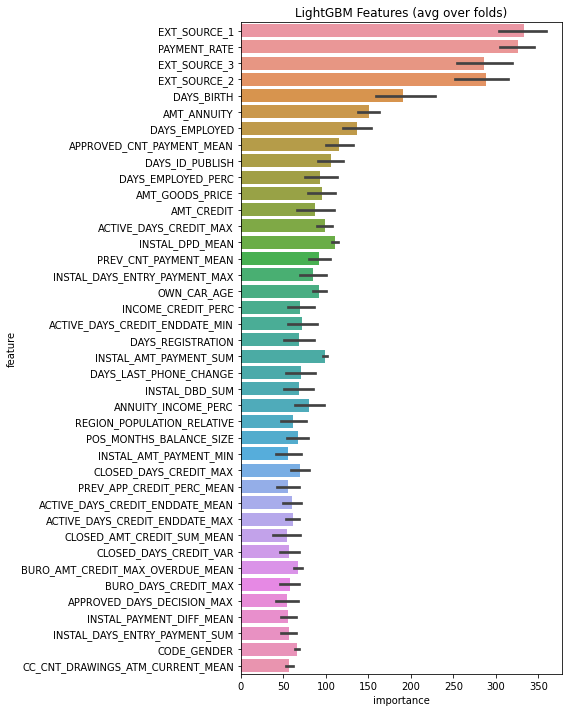

In [38]:
# Display/plot feature importance
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances01.png')